In [1]:
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import os
from os import listdir as ld
from os.path import join as pj
import numpy as np
import pandas as pd
from scipy import ndimage
import h5py
from scipy import sparse
from tqdm import tqdm

from IO.loader import parse_annotations, file_id
from evaluation.classification.statistics import compute_anno_stats, compute_average_size, compute_size_correction
from evaluation.classification.visualize import plot_size_of_anno, plot_size_by_class_of_anno
from utils.crop import *
from utils.annotate import *
from IO.build_ds import build_classification_ds

import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [2]:
root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
anno_folders = ["annotations_0","annotations_2","annotations_3","annotations_4"]
annos = []
for anno_folder in anno_folders:
    annos_name = ld(pj(root, anno_folder))
    annos.extend([pj(root, anno_folder, x) for x in annos_name])
imgs  = ld(pj(root, "refined_images"))
imgs = [img for img in imgs if img != ".ipynb_checkpoints"]
imgs  = [pj(root, "refined_images", x) for x in imgs]

In [3]:
images = {file_id(im):np.array(Image.open(im)) for im in imgs}
annotations = {idx: list(filter(lambda x:idx in x, annos)) for idx in images}
annotations = {k:v for  k,v in annotations.items() if len(v)>0}

anno = {}
for k,v in annotations.items():
    anno[k]=[]
    for x in filter(lambda x:x.endswith(".xml"), v):
        anno[k].extend(parse_annotations(x))

# Visualize annotations

In [4]:
H,W,C,center,idx = compute_anno_stats(anno)

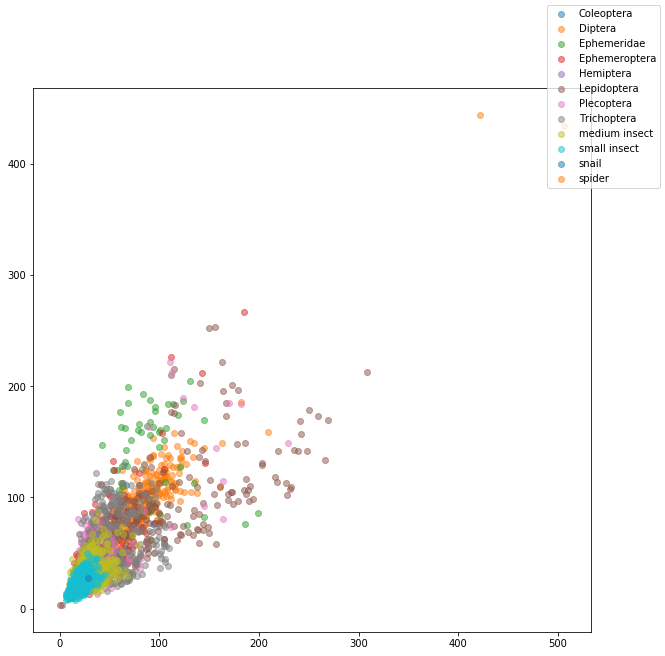

In [5]:
plot_size_by_class_of_anno(H,W,C)

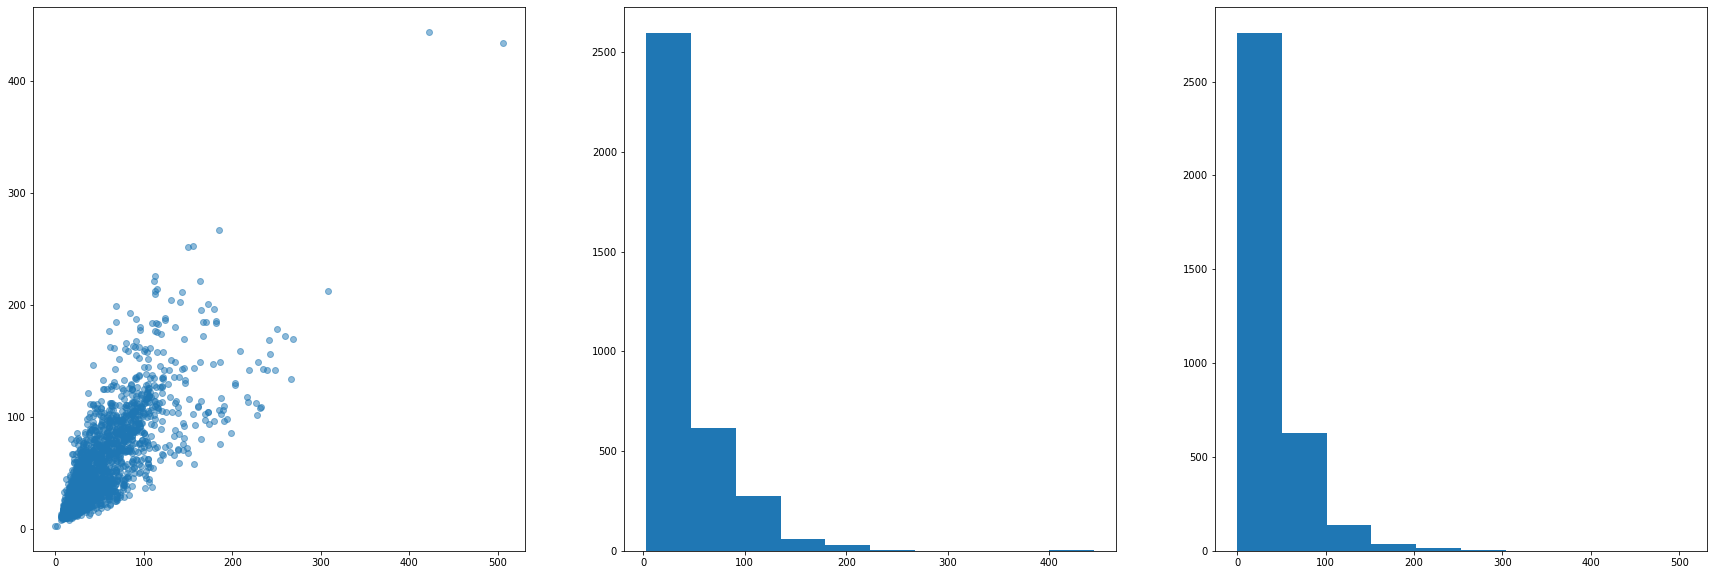

In [6]:
plot_size_of_anno(W,H)

# Dataset Analysis

In [7]:
def calculate_class_stat(H, W, C):
    mean_size = []
    labels, counts = np.unique(C, return_counts=True)
    for label in labels:
        label_filter = C == label
        filtered_H = H[label_filter]
        filtered_W = W[label_filter]
        size = filtered_H * filtered_W
        mean_size.append(size.mean())
    return labels, counts, np.asarray(mean_size)

def remove_unused_label(labels, counts, mean_size, unused_labels=[]):
    for unused_label in unused_labels:
        unused_filter = labels != unused_label
        labels = labels[unused_filter]
        counts = counts[unused_filter]
        mean_size = mean_size[unused_filter]
    return labels, counts, mean_size

def get_relative_mean_size(mean_size):
    min_size = mean_size.min()
    relative_mean_size = mean_size / min_size
    return relative_mean_size

In [8]:
unused_labels = ["snail", "spider"]
labels, counts, mean_size = calculate_class_stat(H, W, C)
labels, counts, mean_size = remove_unused_label(labels, counts, mean_size, unused_labels)
relative_mean_size = get_relative_mean_size(mean_size)
df = pd.DataFrame({"label": labels, "count": counts, "mSize": mean_size, "relative_mSize": relative_mean_size})
df

,label,count,mSize,relative_mSize
0,Coleoptera,30,2036.500000,5.267316
1,Diptera,419,6207.202864,16.054651
2,Ephemeridae,51,13069.333333,33.803244
3,Ephemeroptera,200,2803.800000,7.251903
4,Hemiptera,19,1005.526316,2.600749
5,Lepidoptera,271,9864.719557,25.514654
6,Plecoptera,134,4010.194030,10.372187
7,Trichoptera,250,3700.896000,9.572201
8,medium insect,508,1028.966535,2.661376
9,small insect,1698,386.629564,1.000000


In [9]:
size_sorted_df = df.sort_values("relative_mSize")
size_sorted_df

,label,count,mSize,relative_mSize
9,small insect,1698,386.629564,1.000000
4,Hemiptera,19,1005.526316,2.600749
8,medium insect,508,1028.966535,2.661376
0,Coleoptera,30,2036.500000,5.267316
3,Ephemeroptera,200,2803.800000,7.251903
7,Trichoptera,250,3700.896000,9.572201
6,Plecoptera,134,4010.194030,10.372187
1,Diptera,419,6207.202864,16.054651
5,Lepidoptera,271,9864.719557,25.514654
2,Ephemeridae,51,13069.333333,33.803244


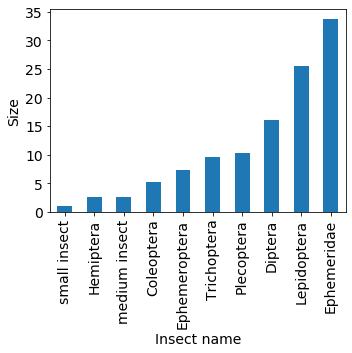

In [10]:
plt.rcParams['figure.figsize'] = (5,5)
size_sorted_df.plot(kind="bar", x="label", y="relative_mSize", legend=False, fontsize=14)
plt.xlabel("Insect name", fontsize=14)
plt.ylabel("Size", fontsize=14)
plt.tight_layout()
if os.path.exists(pj(os.getcwd(), "result/classification/visualize_annotation")) is False:
    os.makedirs(pj(os.getcwd(), "result/classification/visualize_annotation"))
plt.savefig(pj(os.getcwd(), "result/classification/visualize_annotation", "average_size.png"))

In [11]:
count_sorted_df = df.sort_values("count")
count_sorted_df

,label,count,mSize,relative_mSize
4,Hemiptera,19,1005.526316,2.600749
0,Coleoptera,30,2036.500000,5.267316
2,Ephemeridae,51,13069.333333,33.803244
6,Plecoptera,134,4010.194030,10.372187
3,Ephemeroptera,200,2803.800000,7.251903
7,Trichoptera,250,3700.896000,9.572201
5,Lepidoptera,271,9864.719557,25.514654
1,Diptera,419,6207.202864,16.054651
8,medium insect,508,1028.966535,2.661376
9,small insect,1698,386.629564,1.000000


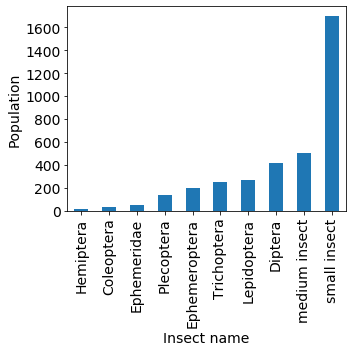

In [12]:
plt.rcParams['figure.figsize'] = (5,5)
count_sorted_df.plot(kind="bar", x="label", y="count", legend=False, fontsize=14)
plt.xlabel("Insect name", fontsize=14)
plt.ylabel("Population", fontsize=14)
plt.tight_layout()
plt.savefig(pj(os.getcwd(), "result/classification/visualize_annotation", "population.png"))

### Train

In [13]:
root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
anno_folders = ["annotations_0","annotations_2","annotations_3"]
annos = []
for anno_folder in anno_folders:
    annos_name = ld(pj(root, anno_folder))
    annos.extend([pj(root, anno_folder, x) for x in annos_name])
imgs  = ld(pj(root, "refined_images"))
imgs = [img for img in imgs if img != ".ipynb_checkpoints"]
imgs  = [pj(root, "refined_images", x) for x in imgs]

In [14]:
images = {file_id(im):np.array(Image.open(im)) for im in imgs}
annotations = {idx: list(filter(lambda x:idx in x, annos)) for idx in images}
annotations = {k:v for  k,v in annotations.items() if len(v)>0}

anno = {}
for k,v in annotations.items():
    anno[k]=[]
    for x in filter(lambda x:x.endswith(".xml"), v):
        anno[k].extend(parse_annotations(x))

In [15]:
H,W,C,center,idx = compute_anno_stats(anno)

In [16]:
unused_labels = ["snail", "spider"]
labels, counts, mean_size = calculate_class_stat(H, W, C)
labels, counts, mean_size = remove_unused_label(labels, counts, mean_size, unused_labels)
relative_mean_size = get_relative_mean_size(mean_size)
df = pd.DataFrame({"label": labels, "count": counts, "mSize": mean_size, "relative_mSize": relative_mean_size})
df

,label,count,mSize,relative_mSize
0,Coleoptera,28,2086.571429,6.245921
1,Diptera,364,5737.686813,17.175133
2,Ephemeridae,38,12692.447368,37.993441
3,Ephemeroptera,169,2576.579882,7.712708
4,Hemiptera,19,1005.526316,3.009932
5,Lepidoptera,231,9715.038961,29.080897
6,Plecoptera,128,3928.703125,11.760139
7,Trichoptera,224,3702.303571,11.082437
8,medium insect,431,944.686775,2.827816
9,small insect,1325,334.069434,1.000000


In [17]:
count_sorted_df = df.sort_values("count")
count_sorted_df

,label,count,mSize,relative_mSize
4,Hemiptera,19,1005.526316,3.009932
0,Coleoptera,28,2086.571429,6.245921
2,Ephemeridae,38,12692.447368,37.993441
6,Plecoptera,128,3928.703125,11.760139
3,Ephemeroptera,169,2576.579882,7.712708
7,Trichoptera,224,3702.303571,11.082437
5,Lepidoptera,231,9715.038961,29.080897
1,Diptera,364,5737.686813,17.175133
8,medium insect,431,944.686775,2.827816
9,small insect,1325,334.069434,1.000000


### Test

In [18]:
root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
anno_folders = ["annotations_4"]
annos = []
for anno_folder in anno_folders:
    annos_name = ld(pj(root, anno_folder))
    annos.extend([pj(root, anno_folder, x) for x in annos_name])
imgs  = ld(pj(root, "refined_images"))
imgs = [img for img in imgs if img != ".ipynb_checkpoints"]
imgs  = [pj(root, "refined_images", x) for x in imgs]

In [19]:
images = {file_id(im):np.array(Image.open(im)) for im in imgs}
annotations = {idx: list(filter(lambda x:idx in x, annos)) for idx in images}
annotations = {k:v for  k,v in annotations.items() if len(v)>0}

anno = {}
for k,v in annotations.items():
    anno[k]=[]
    for x in filter(lambda x:x.endswith(".xml"), v):
        anno[k].extend(parse_annotations(x))

In [20]:
H,W,C,center,idx = compute_anno_stats(anno)

In [21]:
unused_labels = []
labels, counts, mean_size = calculate_class_stat(H, W, C)
labels, counts, mean_size = remove_unused_label(labels, counts, mean_size, unused_labels)
relative_mean_size = get_relative_mean_size(mean_size)
df = pd.DataFrame({"label": labels, "count": counts, "mSize": mean_size, "relative_mSize": relative_mean_size})
df

,label,count,mSize,relative_mSize
0,Coleoptera,2,1335.500000,2.329342
1,Diptera,55,9314.545455,16.246174
2,Ephemeridae,13,14171.000000,24.716668
3,Ephemeroptera,31,4042.516129,7.050845
4,Lepidoptera,40,10729.125000,18.713444
5,Plecoptera,6,5748.666667,10.026666
6,Trichoptera,26,3688.769231,6.433850
7,medium insect,77,1500.714286,2.617505
8,small insect,373,573.337802,1.000000


In [22]:
count_sorted_df = df.sort_values("count")
count_sorted_df

,label,count,mSize,relative_mSize
0,Coleoptera,2,1335.500000,2.329342
5,Plecoptera,6,5748.666667,10.026666
2,Ephemeridae,13,14171.000000,24.716668
6,Trichoptera,26,3688.769231,6.433850
3,Ephemeroptera,31,4042.516129,7.050845
4,Lepidoptera,40,10729.125000,18.713444
1,Diptera,55,9314.545455,16.246174
7,medium insect,77,1500.714286,2.617505
8,small insect,373,573.337802,1.000000
